# Introduction
---
This project analyzes the performance of the S&P 500 index over the last five years. As a benchmark representing 500 of the largest U.S. public companies, the S&P 500 is a vital barometer of the American economy. By applying statistical calculations and data visualization, we will quantify its historical trends, volatility, and risk to build a deeper, data-driven understanding of the market's behavior.

We will use Open, High, Low, Close, and volume data to predict the next few days of closing price for the S&P 500 using Long Short-Term Memory neural network.

# Data Introduction
---
The data is taken from the Yahoo Finance API, and the symbol name for the S&P500 is "^GSPC". We will look at the 5 year period. All the code should be all commented so that it's easier to understand.

# Pre-processing/Feature engineering
---

## Imports

In [307]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [308]:
# data wrangling
import polars as pl
import numpy as np

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

# yfinance api
import yfinance as yf

# for future classes
from dataclasses import dataclass
from typing import List, Union

# neural networks
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# sklearn for preprocessing
from sklearn.preprocessing import MinMaxScaler

## Configuration

In [309]:
with pl.Config() as cfg:
  cfg.set_tbl_cols(None)
  cfg.set_tbl_rows(500)

## Data Information

In [310]:
# download dataset
symbol = ["^GSPC"]
df = yf.download(symbol, period="5y").reset_index()
df.columns = df.columns.get_level_values(0)

/tmp/ipython-input-491198564.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="5y").reset_index()
[*********************100%***********************]  1 of 1 completed


In [311]:
# convert to polars data frame
sp500 = pl.from_pandas(df)

In [312]:
# (rows, columns)
sp500.shape

(1256, 6)

In [313]:
# last 5 rows
sp500.tail()

Date,Close,High,Low,Open,Volume
datetime[ns],f64,f64,f64,f64,i64
2025-09-08 00:00:00,6495.149902,6508.669922,6483.290039,6498.089844,5211500000
2025-09-09 00:00:00,6512.609863,6518.22998,6483.080078,6503.330078,4798350000
2025-09-10 00:00:00,6532.040039,6555.970215,6516.339844,6550.290039,5253010000
2025-09-11 00:00:00,6587.470215,6592.890137,6545.799805,6554.410156,5426460000
2025-09-12 00:00:00,6584.290039,6600.209961,6579.490234,6590.660156,2978174000


In [314]:
# Summary statistics
sp500.describe()

statistic,Date,Close,High,Low,Open,Volume
str,str,f64,f64,f64,f64,f64
"""count""","""1256""",1256.0,1256.0,1256.0,1256.0,1256.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0
"""mean""","""2023-03-13 01:38:35.923566""",4662.402946,4687.585932,4633.526741,4661.210049,4.3668e9
"""std""",null,806.863352,806.626736,805.701586,806.70446,9.5849e8
"""min""","""2020-09-14 00:00:00""",3236.919922,3278.699951,3209.449951,3226.139893,0.0
"""25%""","""2021-12-10 00:00:00""",4060.429932,4080.47998,4022.939941,4052.02002,3.7884e9
"""50%""","""2023-03-14 00:00:00""",4436.75,4457.299805,4408.379883,4437.589844,4.2013e9
"""75%""","""2024-06-11 00:00:00""",5303.27002,5325.319824,5257.629883,5298.689941,4.7562e9
"""max""","""2025-09-12 00:00:00""",6587.470215,6600.209961,6579.490234,6590.660156,9.9765e9


In [315]:
# Null counts
sp500.null_count()

Date,Close,High,Low,Open,Volume
u32,u32,u32,u32,u32,u32
0,0,0,0,0,0


## Feature Engineering

In [316]:
sp500 = sp500.rename(str.lower)

In [317]:
def calculate_rsi(close_prices, window=14):
  delta = close_prices.diff()
  gain = delta.clip(lower_bound=0)
  loss = (-delta).clip(lower_bound=0)

  avg_gain = gain.rolling_mean(window)
  avg_loss = loss.rolling_mean(window)

  rs = avg_gain / avg_loss
  rsi = 100 - (100 / (1 + rs))
  return rsi

In [318]:
# creating a bunch of features
sp500 = sp500.with_columns(
    sma_50 = pl.col("close").rolling_mean(50), # simple moving average that represents closing prices of a stock averaged over 50 days
    sma_200 = pl.col("close").rolling_mean(200), # simple moving average that represents closing prices of a stock averaged over 200 days
    daily_return = (pl.col("close") / pl.col("close").shift(1) - 1) * 100,
)

# sp500 = sp500.with_columns(
#     daily_volatility = pl.col("daily_return").std(), # the degree a price fluctuates, where high volatility indicates larger swings and lower volatility is smaller swings
# )

sp500 = sp500.with_columns(
    rolling_volatility_30d = pl.col("daily_return").rolling_std(30),
    rolling_vol_60d = pl.col("daily_return").rolling_std(60) * (252**0.5),
    rsi_14 = calculate_rsi(pl.col('close'), 14),
    price_change_pct = (pl.col('close') / pl.col('close').shift(1) - 1) * 100,  # percentage change
    volume_sma = pl.col("volume").rolling_mean(20),  # volume moving average
    high_low_pct = ((pl.col('high') - pl.col('low')) / pl.col('close')) * 100,  # daily range
)

In [319]:
# last 5 records of dataframe
sp500.tail()

date,close,high,low,open,volume,sma_50,sma_200,daily_return,rolling_volatility_30d,rolling_vol_60d,rsi_14,price_change_pct,volume_sma,high_low_pct
datetime[ns],f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-09-08 00:00:00,6495.149902,6508.669922,6483.290039,6498.089844,5211500000,6356.628975,5972.22604,0.210598,0.673626,9.724536,54.863192,0.210598,4.5939e9,0.390751
2025-09-09 00:00:00,6512.609863,6518.22998,6483.080078,6503.330078,4798350000,6363.419775,5975.320989,0.268815,0.674676,9.714639,61.183731,0.268815,4.6012e9,0.539721
2025-09-10 00:00:00,6532.040039,6555.970215,6516.339844,6550.290039,5253010000,6369.961572,5978.396289,0.298347,0.672413,9.360638,64.925746,0.298347,4.6071e9,0.606707
2025-09-11 00:00:00,6587.470215,6592.890137,6545.799805,6554.410156,5426460000,6377.750781,5981.748091,0.848589,0.685275,9.329768,72.34309,0.848589,4.6186e9,0.714847
2025-09-12 00:00:00,6584.290039,6600.209961,6579.490234,6590.660156,2978174000,6384.888184,5984.925991,-0.048276,0.679885,9.112293,64.944448,-0.048276,4.5444e9,0.314684


In [320]:
# more null counting
sp500.null_count()

date,close,high,low,open,volume,sma_50,sma_200,daily_return,rolling_volatility_30d,rolling_vol_60d,rsi_14,price_change_pct,volume_sma,high_low_pct
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,49,199,1,30,60,14,1,19,0


In [321]:
# drop the rows that are shifted
sp500 = sp500.drop_nulls()

## Visualization

In [322]:
# install matplotlib finance for market plots
!pip install mplfinance

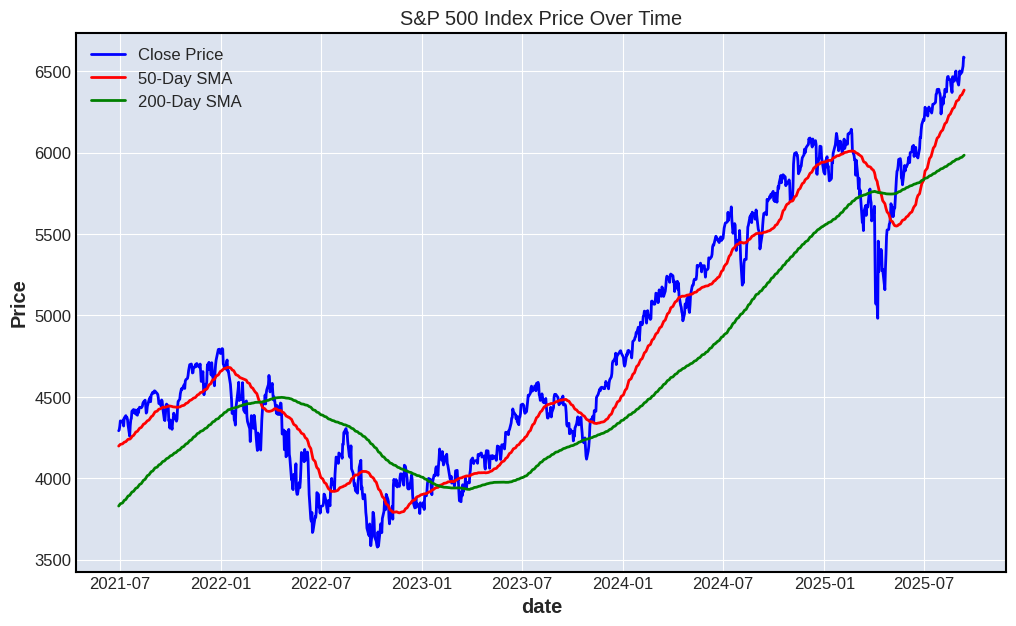

In [323]:
import mplfinance as mpf

# create figure
plt.figure(figsize=(12, 7))

# make three lines for close prices and simple moving averages
ax = sns.lineplot(
    data=sp500,
    x="date",
    y="close",
    label="Close Price",
    color="blue"
)

sns.lineplot(
    data=sp500,
    x="date",
    y="sma_50",
    label="50-Day SMA",
    color="red"
)

sns.lineplot(
    data=sp500,
    x="date",
    y="sma_200",
    label="200-Day SMA",
    color="green"
)

plt.title("S&P 500 Index Price Over Time")
plt.xlabel("date")
plt.ylabel("Price")
plt.show()

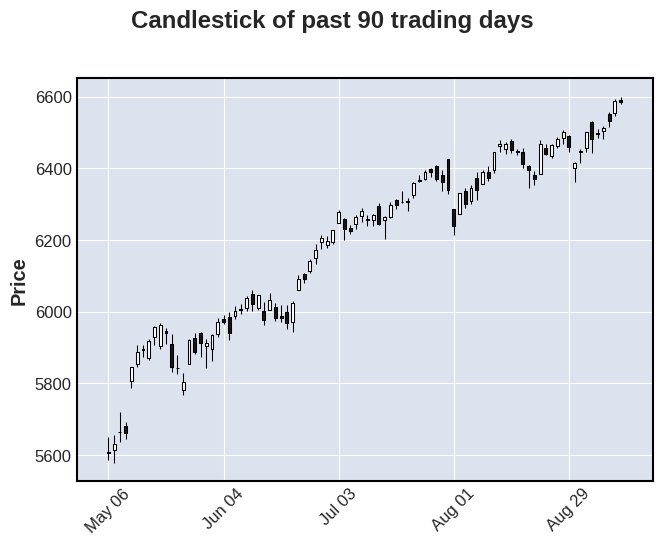

In [324]:
# candlestick pattern chart
mpf.plot(sp500.to_pandas().set_index("date").iloc[-90:], type="candle", title="Candlestick of past 90 trading days")

## Preprocessing for model

In [325]:
# declare features of interest
features = ['close', 'open', 'high', 'low', 'volume', 'sma_50', 'rsi_14', 'rolling_volatility_30d', 'high_low_pct']

# set target variable
target_feature = 'price_change_pct'

# set feature and target data
feature_data = sp500.select(features).to_numpy()
target_data  = sp500.select(target_feature).to_numpy().reshape(-1, 1)

# initialize scaler and scale features
feature_scaler = MinMaxScaler(feature_range=(0, 1)) # scales each feature to given between 0 and 1
scaled_features = feature_scaler.fit_transform(feature_data)

# initialize scaler and scale target
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target_data)

In [326]:
prediction_window = 60
X, y = [], []

# use last 60 days of data to predict next day's close
for i in range(prediction_window, len(scaled_features)):
  # X contains the previous 60 days of all features
  X.append(scaled_features[i-prediction_window:i])

  # y contains the next day's closing price
  y.append(scaled_target[i, 0])

# convert lists into numpy arrays
X, y = np.array(X), np.array(y)

print(X.shape, y.shape) # (samples, timesteps, features) (samples)

(997, 60, 9) (997,)


In [327]:
# initialize 80/20 train test split manually
split_index = int(len(X) * 0.8)

# trian goes from first index of dataset to whatever index 80% of the length is and test set gets remaining 20%
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# convert np arrays into tensors b/c it's PyTorches fundamental data structure and we can use GPU acceleration
X_train_tensor = torch.from_numpy(X_train).float()

# use the unsqueeze method b/c MSELoss criterion expects the shape of target tensor
# to have same shape as output tensor from the model (nn.Layer)
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)

# convert test sets to tensors
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

In [328]:
# check for any null values again just in case
print(f"Any NaN in X_train: {torch.isnan(X_train_tensor).any()}")
print(f"Any NaN in y_train: {torch.isnan(y_train_tensor).any()}")

print(f"Any Inf in X_train: {torch.isinf(X_train_tensor).any()}")
print(f"Any Inf in y_train: {torch.isinf(y_train_tensor).any()}")

Any NaN in X_train: False
Any NaN in y_train: False
Any Inf in X_train: False
Any Inf in y_train: False


# Modeling
---

In [329]:
# @title
# class that inherits from nn.Module class
class LSTMModel(nn.Module):
  # constructor, which is called when you create an instance of LSTMModel
  def __init__(self, input_size, hidden_size, num_layers, dropout_rate, output_size):
    # calls constructor of parent class (nn.Module)
    super(LSTMModel, self).__init__()

    # number of features in each time step of input sequence (6 features)
    self.input_size = input_size

    # number of features in hidden state of LSTM, which is the layer that learns complex patterns
    self.hidden_size = hidden_size

    # number of stacked LSTM layers
    self.num_layers = num_layers

    # probability of an element being zeroed in output of LSTM layers
    # also a regularization technique to prevent overfitting
    self.dropout_rate = dropout_rate

    # number of output features, which is 1 because we have one target
    self.output_size = output_size

    # define lstm layer
    # batch_first specifies input and output tensors will have the same
    # batch dimension as the first dimension
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)

    # additional dropout layer
    self.dropout = nn.Dropout(self.dropout_rate)

    # define the fully connected linear output layer, this is a linear
    # transformation or dense layer
    self.fc1 = nn.Linear(hidden_size, hidden_size // 2)

    # normalizes inputs to speed up and stabilize neural network
    self.bn1 = nn.BatchNorm1d(hidden_size // 2)

    # another layer
    self.fc2 = nn.Linear(hidden_size // 2, output_size)

    # nonlinear activation function
    self.relu = nn.ReLU()

  # forward pass with x being the input tensor of the model
  def forward(self, x):
    # init hidden state h0, which is a tensor of zeroes ensuring the hidden
    # state goes to our T4 GPU on Google Colab
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

    # init cell state, which is similar to hidden state
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

    # returns output LSTM for each time step and final hidden states
    # the shape of this will be (batch_size, sequence_length, hidden_size)
    out, _ = self.lstm(x, (h0, c0))
    out = self.dropout(out[:, -1, :])

    # passes output from last time step through fully connected layer
    # this selects all batches, the last time step, and all hidden features
    out = self.fc1(out)
    if out.size(0) > 1:
      out = self.bn1(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.fc2(out)
    return out

In [330]:
!pip install optuna

In [331]:
import optuna
from torch.amp import autocast, GradScaler

# define the objective function for optuna hyperparameter tuning
def objective(trial):
  # suggest a range of integers for all these params
  hidden_size = trial.suggest_int("hidden_size", 64, 128, step=16)
  num_layers = trial.suggest_int("num_layers", 1, 2)
  dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4)
  learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

  # set the device to the T4 GPU if available, for faster computation
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # initialize model
  model = LSTMModel(input_size=X_train_tensor.shape[2],
                    hidden_size=hidden_size,
                    num_layers=num_layers,
                    dropout_rate=dropout_rate,
                    output_size=1).to(device)

  # initialize Adam optimizer with suggested learning rate float number
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

  # initialize loss function
  criterion = nn.MSELoss()

  # init GradientSclaer for mixed precision training, which speeds up training
  # process on GPUs
  scaler = GradScaler()

  # number of training epochs for each trial
  num_epochs = 20

  # iterate through each training epoch
  for epoch in range(num_epochs):
    # training mode
    model.train()

    # move training data to GPU
    train_inputs = X_train_tensor.to(device)
    train_targets = y_train_tensor.to(device)

    # clear gradient from previous training step
    optimizer.zero_grad()

    # enable mixed precision training
    with autocast(device_type=device.type):
      # perform forward pass to get predictions
      outputs = model(train_inputs)

      # calculate training loss
      loss = criterion(outputs, train_targets)

    # compute gradients using scaled loss
    scaler.scale(loss).backward()

    # updates model's weights based on gradients
    scaler.step(optimizer)

    # updates the scaler for next iteration
    scaler.update()

  # evaluation mode (disabled dropout)
  model.eval()

  # moves test data to GPU
  test_inputs = X_test_tensor.to(device)
  test_targets = y_test_tensor.to(device)

  # disables gradient calculations during eval
  with torch.no_grad():
    # perform forward pass on test data
    val_outputs = model(test_inputs)

    # calculates the validation loss
    validation_loss = criterion(val_outputs, test_targets)

  # returns validation loss as a scalar
  return validation_loss.item()

In [349]:
# create a study and make sure we are minimizing the loss function
study = optuna.create_study(direction="minimize")

# start the optimizatin with 50 trials
study.optimize(objective, n_trials=20)

[I 2025-09-12 23:07:04,706] A new study created in memory with name: no-name-a4b30cc8-2409-4764-ba94-70278db1b813
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.39285328673874687 and num_layers=1
  warnings.warn(
[I 2025-09-12 23:07:05,035] Trial 0 finished with value: 0.10728658735752106 and parameters: {'hidden_size': 80, 'num_layers': 1, 'dropout_rate': 0.39285328673874687, 'learning_rate': 0.0027729249442750513}. Best is trial 0 with value: 0.10728658735752106.
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.39217695799039887 and num_layers=1
  warnings.warn(
[I 2025-09-12 23:07:05,419] Trial 1 finished with value: 0.20477046072483063 and parame

In [350]:
# get hyperparams that got the smallest loss function value
print(f"Best validation loss: {study.best_value}")
print(f"Best hyperparams: {study.best_params}")

Best validation loss: 0.03416048362851143
Best hyperparams: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.37035521422701645, 'learning_rate': 0.009933102649547007}


In [351]:
best_params = study.best_params

In [352]:
# @title
# initialize GPU, create the final model with the best params we got from study
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model = LSTMModel(
    input_size=X_train.shape[2],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params["num_layers"],
    dropout_rate=best_params["dropout_rate"],
    output_size=1).to(device)
final_model

LSTMModel(
  (lstm): LSTM(9, 64, num_layers=2, batch_first=True, dropout=0.37035521422701645)
  (dropout): Dropout(p=0.37035521422701645, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

## Training

In [353]:
# initialize Adam optimizer
# added weight decay, which is a regularization technique to prevent overfitting
# by adding a penalty for large weights for more smoother learning
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["learning_rate"], weight_decay=1e-5)

# init loss function
criterion = nn.MSELoss()

# mixed precision training
scaler = GradScaler()

In [354]:
# 50 number of epocs, since we already found the best hyperparams
num_epochs = 50
train_losses = []

# iterate through each epoch
for epoch in range(num_epochs):
    # set to training mode
    final_model.train()

    # move tensors to gpu
    train_inputs = X_train_tensor.to(device)
    train_targets = y_train_tensor.to(device)

    # clear gradients, b/c gradients need to reset to zero before calculating
    # the gradients for the current training step, otherwise gradients
    # from previous steps will accumulate on each backward pass
    final_optimizer.zero_grad()

    # enable mixed precision training
    with autocast(device_type=device.type):
        # forward pass
        outputs = final_model(train_inputs)

        # calculate loss between predictions and targets
        loss = criterion(outputs, train_targets)

    # backward pass, which are the gradients of loss with respect to model's
    # params
    scaler.scale(loss).backward()

    # mixed precision step that unscales and performs param updates
    scaler.step(final_optimizer)

    # update GradScaler for next iteration, adjusting the scaling factor
    # based on whether the gradients overflowed or underflowed
    scaler.update()

    train_losses.append(loss.item())

    # just prints the epoch number every 10 epochs for feedback
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')


Epoch [10/50], Loss: 0.076221
Epoch [20/50], Loss: 0.027819
Epoch [30/50], Loss: 0.012892
Epoch [40/50], Loss: 0.008779
Epoch [50/50], Loss: 0.006894


## Evaluation

In [355]:
# set model to evaluation mode
final_model.eval()

# disable gradient calculations
with torch.no_grad():
  # set tensor to GPU
  test_inputs = X_test_tensor.to(device)

  # forward pass
  predictions_tensor = final_model(test_inputs)

# extract the predictions and turn them into a numpy array for plotting
predictions_scaled = predictions_tensor.cpu().numpy()
predicted_pct_changes = target_scaler.inverse_transform(predictions_scaled)

In [356]:
# define test set first index
test_set_start_index = len(sp500) - len(X_test)

# actual prices, one dimensional array
test_actual_prices = sp500.select(pl.col('close').slice(test_set_start_index)).to_numpy().flatten()

# get previous closing prices
previous_prices = sp500.select(pl.col('close').slice(test_set_start_index-1, len(X_test))).to_numpy().flatten()

# add predicted difference to previous day's price
reconstructed_predictions = previous_prices * (1 + predicted_pct_changes.flatten()/ 100)

In [357]:
# actual prices on the days we are testing
print(f"Actual Prices:      {np.round(test_actual_prices[:5], 2)}")

# prices from the day before that we use as a base for prediction
print(f"Previous Day Prices:  {np.round(previous_prices[:5], 2)}")

# final reconstructed predictions
print(f"Reconstructed Predictions:          {np.round(reconstructed_predictions[:5], 2)}")

Actual Prices:      [5969.34 5987.37 6021.63 5998.74 6032.38]
Previous Day Prices:  [5948.71 5969.34 5987.37 6021.63 5998.74]
Reconstructed Predictions:          [5798.92 5819.08 5836.76 5870.22 5847.96]


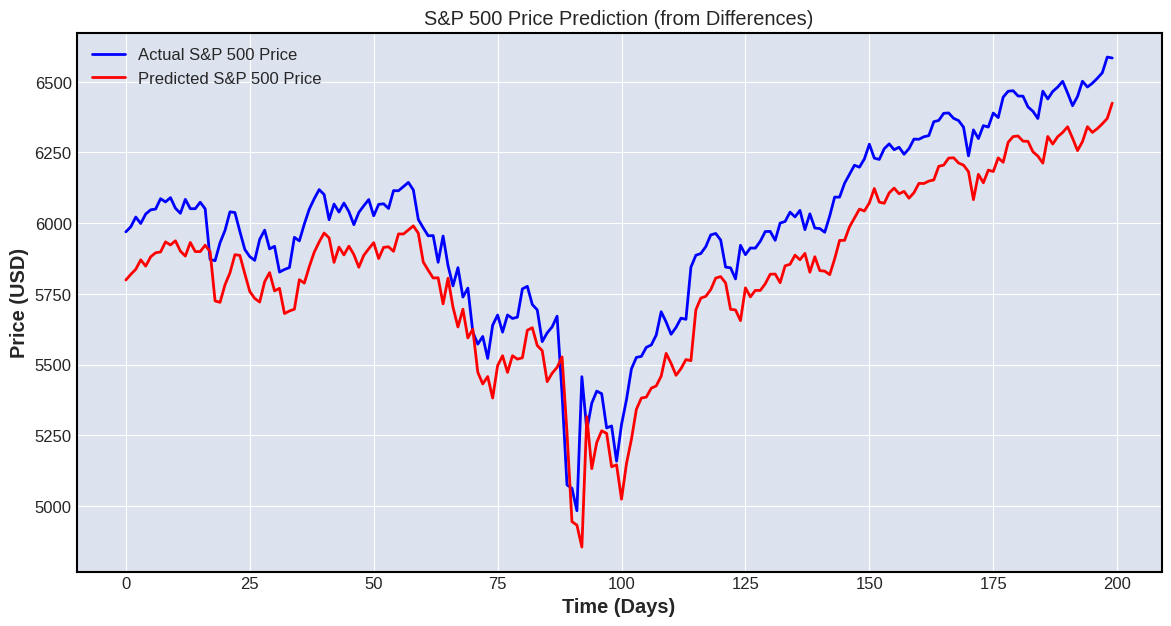

In [358]:
# plot prediction vs actual
plt.figure(figsize=(14, 7))
plt.plot(test_actual_prices, color='blue', label='Actual S&P 500 Price')
plt.plot(reconstructed_predictions, color='red', label='Predicted S&P 500 Price')
plt.title('S&P 500 Price Prediction (from Differences)')
plt.xlabel('Time (Days)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

* So it's correctly tracing the direction and almost has the right values.

In [359]:
# user scikit-learn metrics to perform scores
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_actual_prices, reconstructed_predictions)
mse = mean_squared_error(test_actual_prices, reconstructed_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_actual_prices, reconstructed_predictions)

print("Model Performance Metrics")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"R-squared (R2) Score: {r2:.4f}")

Model Performance Metrics
Mean Absolute Error (MAE): $157.81
Root Mean Squared Error (RMSE): $169.00
R-squared (R2) Score: 0.7261


## Predicting the next 10 days

In [360]:
def predict_future(
    model, last_sequence, n_days,
    feature_scaler, target_scaler,
    recent_prices, max_daily_change=0.05):
  predictions = []
  current_sequence = last_sequence.copy()

  # calculate recent voltaility for bounds
  recent_changes = np.abs(np.diff(recent_prices[-30:])) / recent_prices[-30:-1]
  avg_volatility = np.mean(recent_changes)
  volatility_bound = min(max_daily_change, avg_volatility * 2)

  # close index
  close_idx = features.index('close')
  sma_idx = features.index('sma_50') if 'sma_50' in features else None

  for day in range(n_days):
    with torch.no_grad():
      pred_tensor = torch.from_numpy(current_sequence).float().unsqueeze(0).to(device)
      scaled_pred = model(pred_tensor).cpu().numpy()[0, 0]

      # inverse transform to get percentage change
      pred_pct_change = target_scaler.inverse_transform([[scaled_pred]])[0, 0]

      # apply realistic bounds to percentage change
      pred_pct_change = np.clip(pred_pct_change, -volatility_bound*100, volatility_bound*100)

      # get last price
      last_scaled_price = current_sequence[-1, close_idx]
      dummy_features = np.zeros((1, len(features)))
      dummy_features[0, close_idx] = last_scaled_price
      last_price = feature_scaler.inverse_transform(dummy_features)[0, close_idx]

      # calculate next day's price
      next_price = last_price * (1 + pred_pct_change / 100)
      predictions.append(next_price)

      # update sequence for next prediction
      new_features = current_sequence[-1].copy()

      # update the close price in the feature vector
      dummy_features = np.zeros((1, len(features)))
      dummy_features[0, close_idx] = next_price
      new_features[close_idx] = feature_scaler.transform(dummy_features)[0, close_idx]

      # update SMA
      if sma_idx is not None:
        current_sma_scaled = current_sequence[-1, sma_idx]
        dummy_features = np.zeros((1, len(features)))
        dummy_features[0, sma_idx] = current_sma_scaled
        current_sma = feature_scaler.inverse_transform(dummy_features)[0, sma_idx]
        new_sma = current_sma * 0.98 + next_price * 0.02  # Simple exponential smoothing
        dummy_features[0, sma_idx] = new_sma
        new_features[sma_idx] = feature_scaler.transform(dummy_features)[0, sma_idx]

      # shift sequence and add new prediction
      current_sequence = np.vstack([current_sequence[1:], new_features.reshape(1, -1)])

  return predictions

In [361]:
from datetime import timedelta

n_future_days = 30
last_sequence = scaled_features[-prediction_window:]
recent_actual_prices = sp500.select(pl.col('close').tail(30)).to_numpy().flatten()

# store the future predictions
future_predictions = predict_future(
    final_model,
    last_sequence,
    n_future_days,
    feature_scaler,
    target_scaler,
    recent_actual_prices,
    max_daily_change=0.04
)

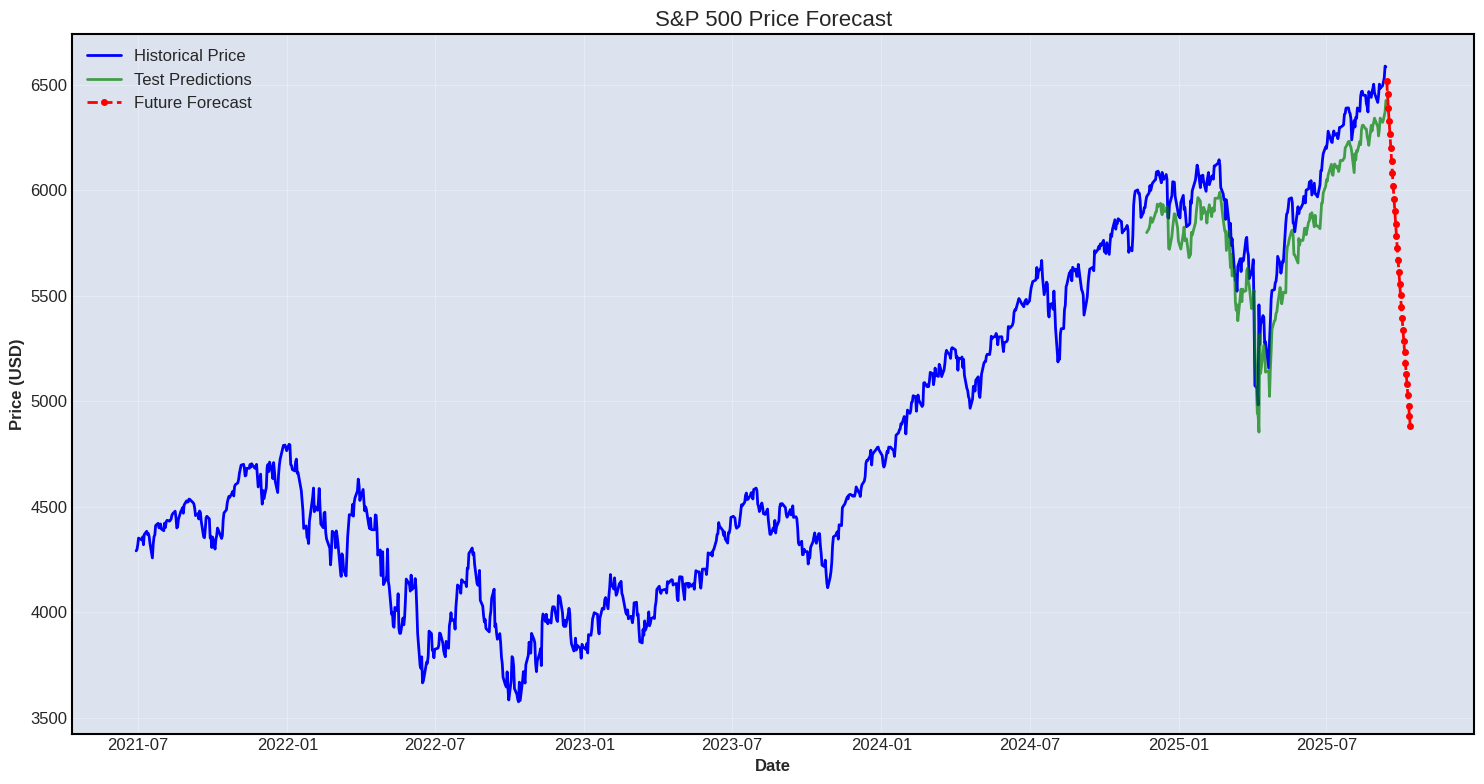

In [362]:
plt.figure(figsize=(15, 8))

# Plot historical data
historical_dates = sp500.select('date').to_numpy().flatten()
historical_prices = sp500.select('close').to_numpy().flatten()

plt.plot(historical_dates, historical_prices, label='Historical Price', color='blue', linewidth=2)

# plot test predictions
test_dates = sp500.select(pl.col('date').slice(test_set_start_index)).to_numpy().flatten()
plt.plot(test_dates, reconstructed_predictions, label='Test Predictions', color='green', alpha=0.7)

# plot future predictions
last_date = sp500.select(pl.last('date')).item()
future_dates = [last_date + timedelta(days=i+1) for i in range(n_future_days)]

plt.plot(future_dates, future_predictions, label='Future Forecast',
         color='red', linestyle='--', linewidth=2, marker='o', markersize=4)

plt.title('S&P 500 Price Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [363]:
last_actual_price = sp500.select(pl.last('close')).item()
print(f"\nFuture Predictions Summary:")
print(f"Last actual price: ${last_actual_price:.2f}")
print(f"Predicted prices for next {n_future_days} days:")
for i, pred in enumerate(future_predictions, 1):
    print(f"Day {i}: ${pred:.2f}")

print(f"\nPredicted total change: {((future_predictions[-1] / last_actual_price) - 1) * 100:.2f}%")
print(f"Average daily change: {np.mean(np.diff(future_predictions) / future_predictions[:-1]) * 100:.2f}%")



Future Predictions Summary:
Last actual price: $6584.29
Predicted prices for next 30 days:
Day 1: $6518.92
Day 2: $6454.20
Day 3: $6390.12
Day 4: $6326.67
Day 5: $6263.86
Day 6: $6201.67
Day 7: $6140.10
Day 8: $6079.14
Day 9: $6018.78
Day 10: $5959.02
Day 11: $5899.86
Day 12: $5841.28
Day 13: $5783.29
Day 14: $5725.87
Day 15: $5669.02
Day 16: $5612.74
Day 17: $5557.01
Day 18: $5501.84
Day 19: $5447.22
Day 20: $5393.13
Day 21: $5339.59
Day 22: $5286.57
Day 23: $5234.09
Day 24: $5182.12
Day 25: $5130.67
Day 26: $5079.73
Day 27: $5029.30
Day 28: $4979.37
Day 29: $4929.93
Day 30: $4880.98

Predicted total change: -25.87%
Average daily change: -0.99%


In [364]:
# Compare with simple baseline
recent_diffs = sp500.select(pl.col('close').diff().tail(30)).to_numpy().flatten()
simple_trend = np.nanmean(recent_diffs)
simple_forecast = [last_actual_price + simple_trend * (i+1) for i in range(n_future_days)]
print(f"Simple trend forecast for day {n_future_days}: ${simple_forecast[-1]:.2f}")

Simple trend forecast for day 30: $6829.19


# Conclusion - How to make the model better
---
The next steps would be to incorporate real-time data because the model can only really predict the trend (red line). It can't really predict every direction the line is going to go. This red line can still be used because the S&P 500 is mostly for long-term trades and just investing your money into there like a savings account. But there are some options-trading strategies that you can make major profit on depending on the direction you believe the stock will go in. Options is actually less risky than stocks, unless you are trading naked calls and puts.

Some ideas that we can think about:
* Use new articles as a sentiment to determine the probability of what direction the stock might go up or down to. Or maybe it stays sideways, which is perfect for an Iron Condor options-trading strategy.
* Risk management system
* Feature engineer the greeks and other technical indicators into our dataframe
* Backtesting system
* Experiment with different models like GRU or Meta's Prophet, which is specifically designed for time series

Trading stocks algorithmically, you probably need real-time data. You can probably use something like NewsAPI, but it might be expensive. The free version has 100 requests a day, which is probably all you need, but news articles have a 24 hour delay. Something cool would be to measure the how news articles psychologically affect people's decision making when trading a financial instrument. I am going to research this a lot more. Hopefully, whatever solution or strategy I found out that it sets me up for life.

### Impact
This project does not harm anyone or anything except maybe your money. You shouldn't just trust this model because this is mostly a baseline model. You'd need other technical indicators and probably recent news to improve or fine tune this model. The main purpose should be to just build upon this.

But technically, you can still use this model as a long-term investment. It does point out the general direction the S&P 500 is going. So, you can probably put like $50 a month in ETFs that track the S&P 500 and just keep it in there for a good 20 years and you'll be positive.

The S&P 500 also doesn't move that much, so you might be able to make some more money with different options trading strategies.

The line looks like it's following a pattern, since the S&P 500 has been going up, it's probably detected a pattern that it needs to go down at some point, but this is very limited since it's just a linear prediction line. Again, this does not capture current events.

### References
- Yahoo Finance API: https://pypi.org/project/yfinance/
- PyTorch: https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html

### Code Assistance
Claude Sonnet 4 helped me make the LSTM class better and added a few recommendations like adding anotehr fully connected layer, additional dropout, weight decay, and batch normalization. It also added volatility bounds to prevent unrealistic predictions, which works by not allowing any daily changes that are bigger than a certain percentage. I've also used Optuna for regular machine learning classification and regression problems, but not for deep learning, so it helped me out a little, but it mostly worked the same way by suggesting numbers for hyperparameters, building the model, and then minimizing the loss function (MSE).

# Convert notebook to html
---

In [365]:
from pathlib import Path
focus_path = Path("/content/drive/MyDrive/Colab Notebooks/Trading the S&P.ipynb")

In [366]:
!jupyter nbconvert --to html "{focus_path}"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Trading the S&P.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 938177 bytes to /content/drive/MyDrive/Colab Notebooks/Trading the S&P.html
